# Libraries, data...

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import calinski_harabasz_score as score_ch
from sklearn.metrics import davies_bouldin_score as score_db
from sklearn.metrics import silhouette_score as score_sc
from GapStat import gap_stat
from statsmodels.tsa.stattools import adfuller

Import data

In [25]:
for i in range(10):
    if i==0:
        ALL_STOCKS=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2)
        NAMES=list(ALL_STOCKS)
        ALL_STOCKS=np.array(ALL_STOCKS)
        SECTOR_ID=np.zeros((ALL_STOCKS.shape[1]))
    else:
        load=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2)
        NAMES=NAMES+list(load)
        ALL_STOCKS=np.append(ALL_STOCKS,np.array(load),axis=1)
        SECTOR_ID=np.append(SECTOR_ID,np.zeros((np.array(load).shape[1]))+i)
SP500=np.array(pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', 'MarketIndex', usecols='B'))
SECTOR_LABELS=['Communication services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Healthcare', 'Industrials','Information Technology', 'Materials', 'Utilities' ]

In [22]:
df = pd.DataFrame(ALL_STOCKS)

In [23]:
df

,0,1,2,3,4,5,6,7,8,9,...,457,458,459,460,461,462,463,464,465,466
0,2023-04-05,104.47,211.48,104.95,342.35,99.91,40.11,37.92,19.88,149.12,...,89.27,30.39,114.84,62.12,34.41,54.82,24.1,63.15,28.69,80.63
1,2023-04-06,108.42,216.1,108.9,339.33,99.97,40.1325,37.69,19.9275,149.61,...,90.07,30.77,115.42,62.31,34.82,55.05,24.4,63.29,28.82,80.29
2,2023-04-07,108.42,216.1,108.9,339.33,99.97,40.1325,37.69,19.9275,149.61,...,90.07,30.77,115.42,62.31,34.82,55.05,24.4,63.29,28.82,80.29
3,2023-04-10,106.44,214.75,106.95,338.99,100.81,40.0004,38.23,19.8464,149.99,...,90.01,30.68,116.07,61.95,35.18,54.92,24.9,62.84,28.69,80.42
4,2023-04-11,105.35,213.85,106.12,338.21,100.42,40.102,38.38,19.9681,149.95,...,90.17,30.63,116.37,61.73,35.68,55.06,25.35,62.57,28.64,80.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2024-04-08,154.85,519.805,156.14,628.41,117.7293,44.8733,41.8483,18.4436,162.2384,...,75.7888,29.0179,119.5031,61.1414,76.6225,51.2423,18.9706,55.2751,28.51,77.5548
264,2024-04-09,156.6,517.452,158.14,618.2,118.3513,44.6313,41.2727,18.3661,162.3392,...,76.4605,29.0796,119.8215,61.2966,75.5429,51.8019,18.9602,55.474,28.7073,78.1201
265,2024-04-10,156.14,520.385,157.66,618.58,117.5688,44.2816,40.8307,18.1813,161.714,...,74.6934,28.1438,118.219,60.1584,75.9685,50.4444,18.3279,54.1231,28.3542,75.5866
266,2024-04-11,159.41,523.719,160.79,628.78,117.5286,43.8882,41.2624,17.8444,162.0266,...,74.4557,28.3598,117.4999,59.8894,77.4322,50.2371,18.473,53.8927,28.3023,75.5971


Missing data

In [26]:
select=(1-np.sum(np.isnan(ALL_STOCKS),axis=0)==1)
STOCKS_SELECT=ALL_STOCKS[:,select]
select_id=np.arange(0,ALL_STOCKS.shape[1],1)[select]
NAMES_SELECT=[NAMES[i] for i in select_id]
SECTOR_ID_SELECT=SECTOR_ID[select]
n_stocks=STOCKS_SELECT.shape[1]

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Return computation

In [4]:
RETURNS=STOCKS_SELECT[1:,:]/STOCKS_SELECT[:-1,:]-1
RETURNS_NORM=preprocessing.scale(RETURNS)
RETURNS_SP500=SP500[1:,:]/SP500[:-1,:]-1
n_obs=len(RETURNS)

In [5]:
n_stocks=STOCKS_SELECT.shape[1]
n_obs=len(STOCKS_SELECT)
n_pairs=int(n_stocks*(n_stocks-1)/2)

In [6]:
SPREADS=np.zeros((n_obs,n_pairs))
PAIR_RETURNS=np.zeros((n_obs-1,n_pairs))
SPREADS_N=np.zeros((n_obs,n_pairs))

# 1. Pair selection

In [7]:
SELECTED_PAIRS=np.zeros((n_pairs))
SELECTED_STOCKS=np.zeros((n_stocks))
count=0
for i in range(n_stocks):
        for j in np.arange(i+1,n_stocks,1):
            if ((SECTOR_ID_SELECT[i]==SECTOR_ID_SELECT[j])*(SELECTED_STOCKS[i]==0)*(SELECTED_STOCKS[j]==0))==1:
                mu1=np.mean(STOCKS_SELECT[:,i])
                mu2=np.mean(STOCKS_SELECT[:,j])
                hedge=mu1/mu2
                SPREADS[:,count]=np.log(STOCKS_SELECT[:,i])-np.log(hedge*STOCKS_SELECT[:,j])
                PAIR_RETURNS[:,count]=RETURNS[:,i]-RETURNS[:,j]
                SPREADS_N[:,count]=preprocessing.scale(SPREADS[:,count])
                if abs(SPREADS_N[-1,count])>1.5:
                    ### STATIONARITY TEST
                    pval=adfuller(SPREADS_N[:,count], regression='c')[1]
                    if pval<0.05:
                        SELECTED_PAIRS[count]=1
                        SELECTED_STOCKS[i]=1
                        SELECTED_STOCKS[j]=1
            count=count+1
print(sum(SELECTED_PAIRS))

44.0


# 2. Clustering

## 2.1. Principal component analysis

### 2.1.1. From stock returns

5 factors retreiving 39 percent of the global variance


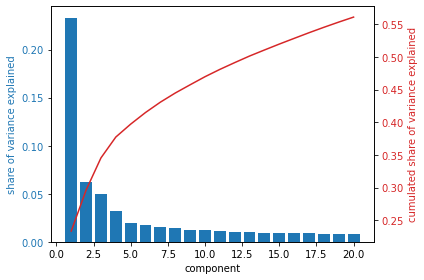

In [8]:
out_pca=PCA(RETURNS_NORM)

share_variance=out_pca.eigenvals[:20]/sum(out_pca.eigenvals)
share_variance_cumulated=np.cumsum(share_variance)

N_FACTORS=min((out_pca.ic[:20,:]).argmin(axis=0))+1
print('%i factors retreiving ' %(N_FACTORS)+ '%i percent of the global variance' %(share_variance_cumulated[N_FACTORS-1]*100))

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('component')
ax1.set_ylabel('share of variance explained', color=color)
ax1.bar(np.arange(1,21,1), share_variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cumulated share of variance explained', color=color)
ax2.plot(np.arange(1,21,1), share_variance_cumulated, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

### 2.1.2. From pair returns

44 factors retreiving 99 percent of the global variance


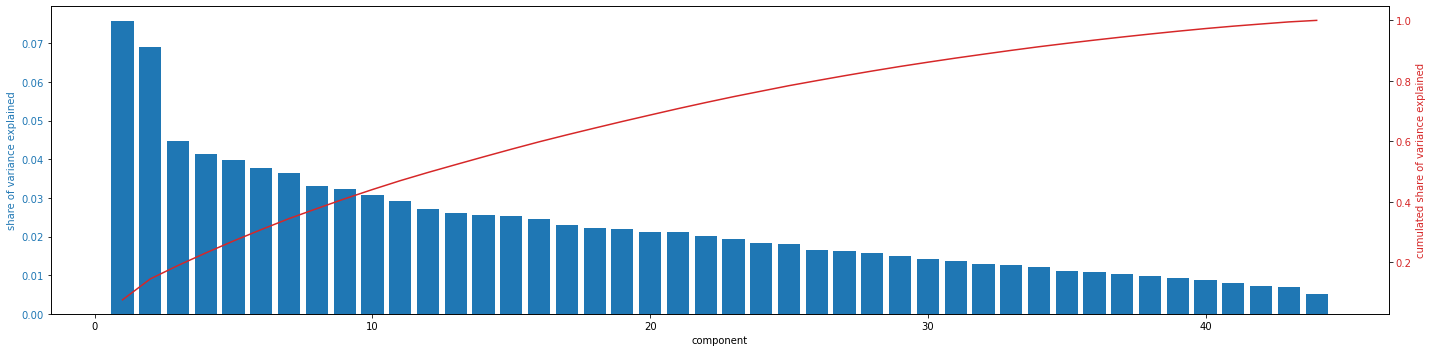

In [28]:
PAIR_RETURNS_N=preprocessing.scale(PAIR_RETURNS[:,SELECTED_PAIRS==1])
out_pca=PCA(PAIR_RETURNS_N)

share_variance=out_pca.eigenvals[:]/sum(out_pca.eigenvals)
share_variance_cumulated=np.cumsum(share_variance)

N_FACTORS=min((out_pca.ic[:,:]).argmin(axis=0))+1
print('%i factors retreiving ' %(N_FACTORS)+ '%i percent of the global variance' %(share_variance_cumulated[-1]*100))


fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('component')
ax1.set_ylabel('share of variance explained', color=color)
ax1.bar(np.arange(1,N_FACTORS+1,1), share_variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cumulated share of variance explained', color=color)
ax2.plot(np.arange(1,N_FACTORS+1,1), share_variance_cumulated, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

## 2.2. Clustering from normalized spread returns

### 2.2.1. Computing Euclidean distance from pair returns

In [30]:
DIST_1=pdist(PAIR_RETURNS_N.T,'euclidean')
clustering_1 = linkage(DIST_1,method='ward')
N_CLUSTER=0

[]

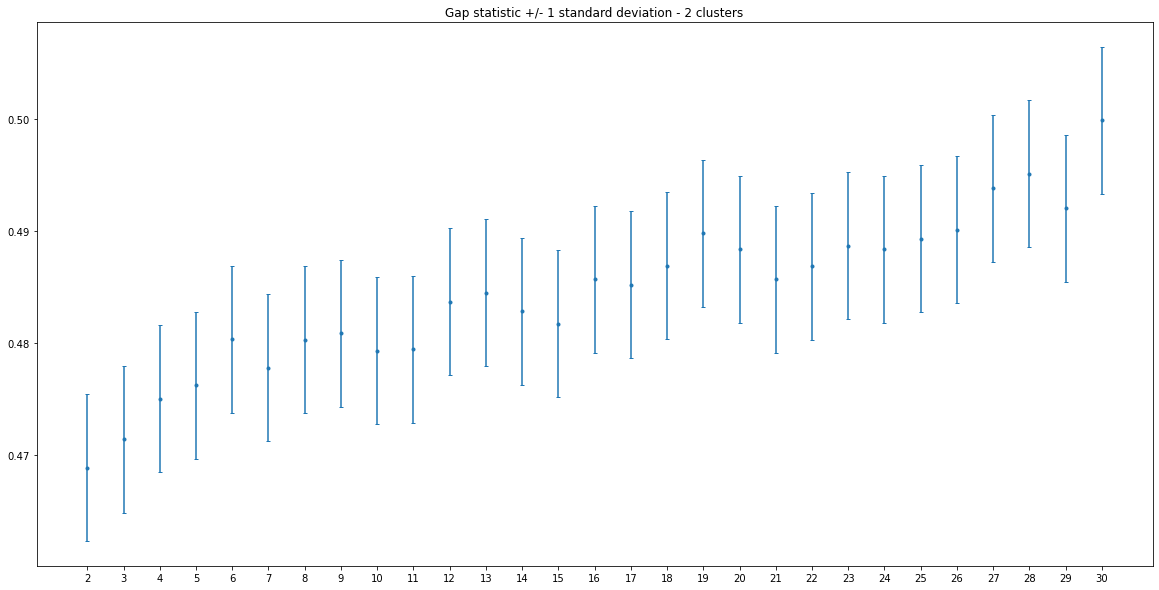

In [31]:
cmax=30
GAP_OUT=np.zeros((cmax-1,2))
for i in np.arange(2,cmax+1,1):
    clusters=fcluster(clustering_1,i,criterion='maxclust')
    out=gap_stat('euclidean', 'ward', PAIR_RETURNS_N, DIST_1, clusters, 20)
    GAP_OUT[i-2,:]=[out[0],out[1]]
std_GAP=np.mean(out[1])
for i in np.arange(2,cmax,1):
    if GAP_OUT[i-2,0]>(GAP_OUT[i-1,0]-GAP_OUT[i-1,1]):
        N_CLUSTER=i
        break

plt.figure(figsize=(20, 10))
plt.errorbar(np.arange(2,cmax+1,1), GAP_OUT[:,0], GAP_OUT[i-1,1], capsize=2, fmt='.')
plt.title("Gap statistic +/- 1 standard deviation - %i clusters" %N_CLUSTER)
plt.xticks(np.arange(2,cmax+1,1))
plt.plot()

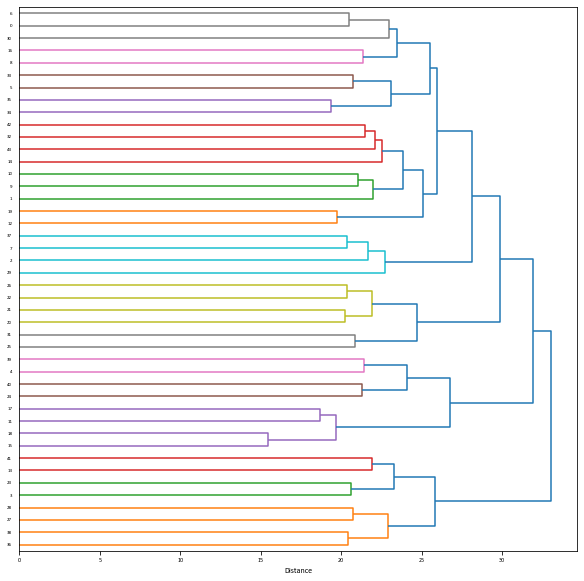

In [32]:
plt.figure(figsize=(10, 10))
csfont = {'fontname':'Calibri', 'fontsize' : '10'}
csfont2 = {'fontname':'Calibri', 'fontsize' : '8'}
csfont3 = {'fontname':'Calibri', 'fontsize' : '6'}
plt.xlabel('Distance',**csfont2)
plt.xticks(**csfont3)
plt.yticks(**csfont3)
dendrogram(clustering_1,truncate_mode='level',orientation='right',leaf_font_size=5)
plt.savefig('books_read.jpeg',bbox_inches='tight', dpi=300)
plt.show()

# 3. Equal CVaR allocation

## 3.1. CVaR computation

In [45]:
CVaR=np.zeros((int(sum(SELECTED_PAIRS))))
SEL_PAIR_RETURNS=PAIR_RETURNS[:,SELECTED_PAIRS==1]

for i in range(len(CVaR)):
    Q05=np.quantile(SEL_PAIR_RETURNS[:,i],0.05)
    CVaR[i]=abs(np.mean(SEL_PAIR_RETURNS[SEL_PAIR_RETURNS[:,i]<Q05,i]))

## 3.2. Portfolio weights

In [46]:
WEIGHTS=(1/CVaR)/np.sum(1/CVaR)